# Machine Learning Model

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the engineered logs
logs_df = pd.read_csv("/Users/davidstroud/cloud_logs/anomaly_detection/engineered_logs_100k.csv")

# Select features and target
features = ['hour', 'action_count', 'failed_actions_count', 'resource_type', 'event_type', 'action', 'region']
target = 'failed_action'  # Using 'failed_action' as the target for simplicity in this example

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(logs_df[features], logs_df[target], test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = ['hour', 'action_count', 'failed_actions_count']
categorical_features = ['resource_type', 'event_type', 'action', 'region']

# Create a column transformer with pipelines for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply preprocessing to training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Train Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
isolation_forest.fit(X_train_processed)

# Predict on test set
y_pred = isolation_forest.predict(X_test_processed)

# Convert predictions to anomaly labels (1 for anomaly, 0 for normal)
# Isolation Forest outputs -1 for anomalies and 1 for normal points, so we convert them
y_pred = [1 if p == -1 else 0 for p in y_pred]

# Evaluate model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82     15222
           1       0.23      0.10      0.14      4778

    accuracy                           0.71     20000
   macro avg       0.49      0.50      0.48     20000
weighted avg       0.63      0.71      0.66     20000

Confusion Matrix:
[[13666  1556]
 [ 4318   460]]
ROC AUC Score: 0.4970270607538086


In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_pred = isolation_forest.predict(X_test_processed)

# Convert predictions to anomaly labels (1 for anomaly, 0 for normal)
# Isolation Forest outputs -1 for anomalies and 1 for normal points, so we convert them
y_pred_isolation_forest = [1 if p == -1 else 0 for p in y_pred]

# Evaluate model
print("Isolation Forest Classification Report:")
print(classification_report(y_test, y_pred_isolation_forest))
print("Isolation Forest Confusion Matrix:")
conf_matrix_if = confusion_matrix(y_test, y_pred_isolation_forest)
print(conf_matrix_if)


Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82     15222
           1       0.23      0.10      0.14      4778

    accuracy                           0.71     20000
   macro avg       0.49      0.50      0.48     20000
weighted avg       0.63      0.71      0.66     20000

Isolation Forest Confusion Matrix:
[[13666  1556]
 [ 4318   460]]


Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82     15222
           1       0.23      0.10      0.14      4778

    accuracy                           0.71     20000
   macro avg       0.49      0.50      0.48     20000
weighted avg       0.63      0.71      0.66     20000

Isolation Forest Confusion Matrix:
[[13666  1556]
 [ 4318   460]]


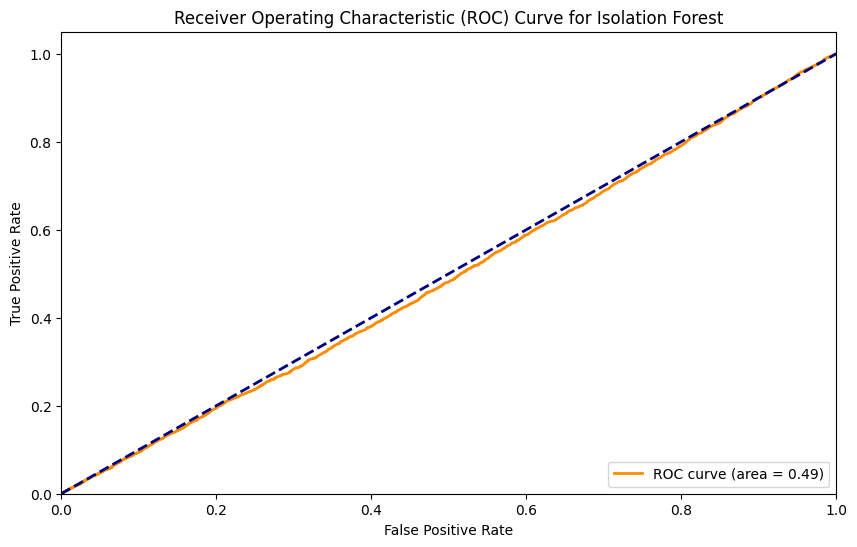

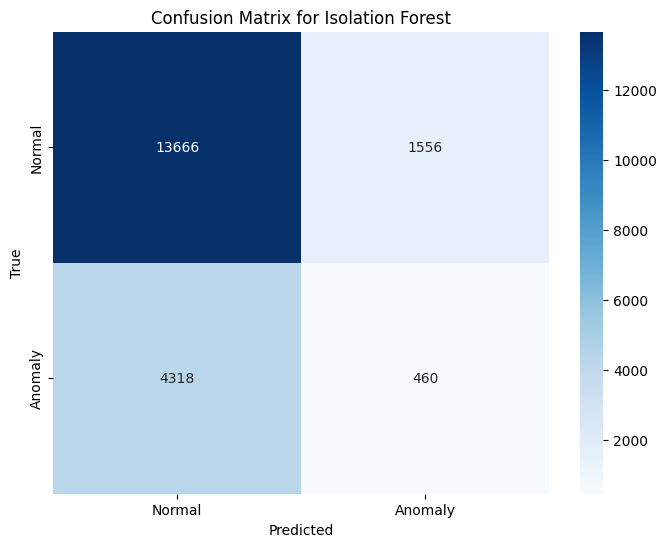

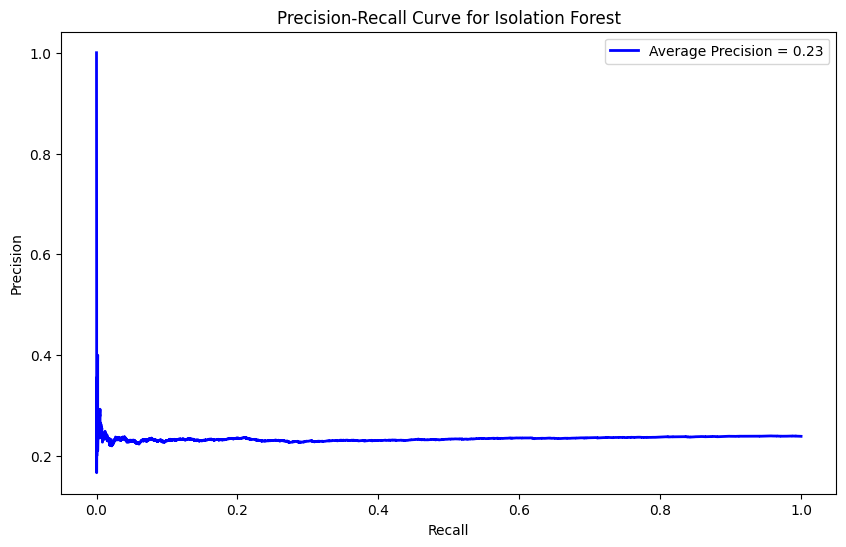

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_pred = isolation_forest.predict(X_test_processed)

# Convert predictions to anomaly labels (1 for anomaly, 0 for normal)
# Isolation Forest outputs -1 for anomalies and 1 for normal points, so we convert them
y_pred_isolation_forest = [1 if p == -1 else 0 for p in y_pred]

# Evaluate model
print("Isolation Forest Classification Report:")
print(classification_report(y_test, y_pred_isolation_forest))
print("Isolation Forest Confusion Matrix:")
conf_matrix_if = confusion_matrix(y_test, y_pred_isolation_forest)
print(conf_matrix_if)

# Since Isolation Forest doesn't provide probability scores, use decision function for ROC curve
y_scores_if = isolation_forest.decision_function(X_test_processed) * -1  # Invert scores as we want high values for anomalies

# Calculate ROC curve
fpr_if, tpr_if, _ = roc_curve(y_test, y_scores_if)
roc_auc_if = auc(fpr_if, tpr_if)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_if, tpr_if, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_if:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Isolation Forest')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_if, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision-recall curve
precision_if, recall_if, _ = precision_recall_curve(y_test, y_scores_if)
average_precision_if = average_precision_score(y_test, y_scores_if)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_if, precision_if, color='blue', lw=2, label=f'Average Precision = {average_precision_if:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Isolation Forest')
plt.legend(loc="upper right")
plt.show()
